In [ ]:
model_name = "meta-llama/Llama-2-7b-chat-hf"

dataset_name = "mlabonne/guanaco-llama2-1k"

##How LoRA Works :

In [ ]:
challenges in full fine tuning of llm :

--> high computational resources required :
--> Training time will be more
--> Previous knowledge may be forgotten

In [ ]:
##parameter efficient fine tuning methods :

In [1]:
from IPython.display import Image, display

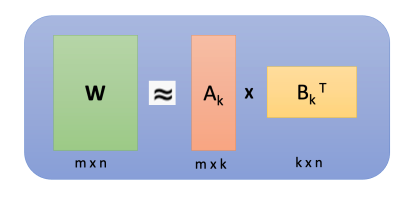

In [2]:
display(Image("/content/Low_rank_decomposition.png"))

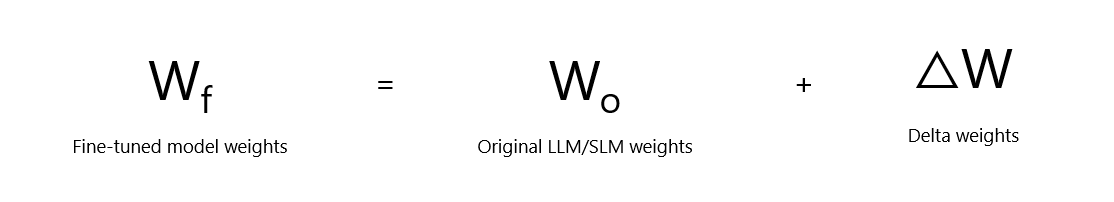

In [3]:
display(Image("/content/lora_weights.png"))

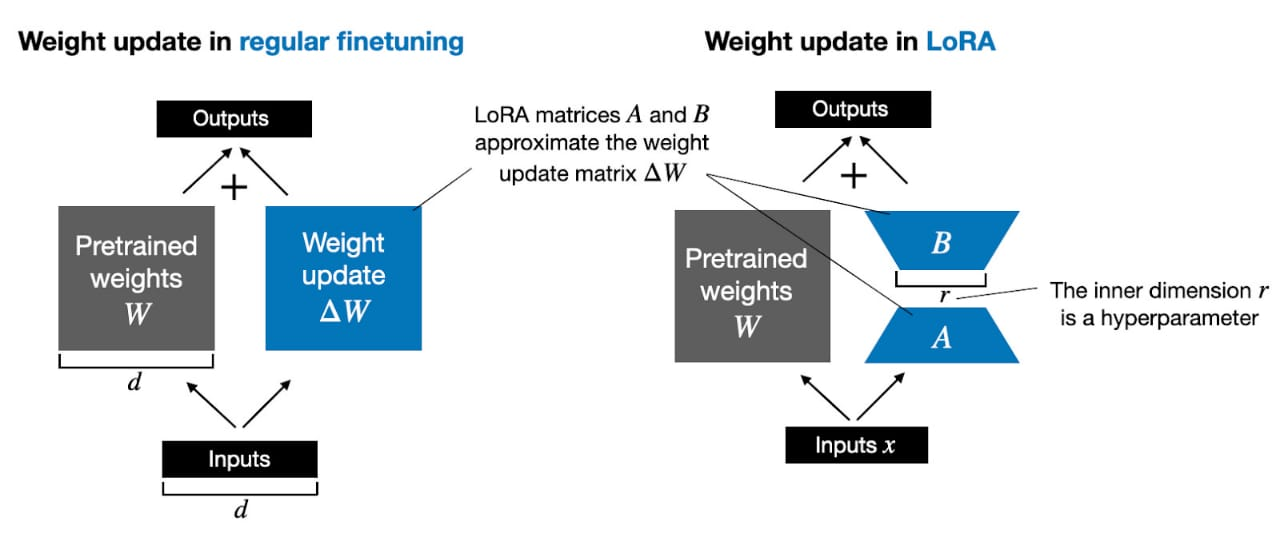

In [4]:
display(Image("/content/LoRA_a&b.jpeg"))

In [ ]:
output = w * X ==> wx

finetuned output = w * X  +  dw + X   ==> wX + dwX

In [ ]:
# Lora
all the weights will be frozen :


In [ ]:
# Advantges of LoRA
only training few parameters, computational cost required will be low and training will be faster


retaining original model weights, we can also retaine knowledge model has acquired




In [ ]:
summarization output = w * X  +  d_s_w + X   ==> wX + d_s_wX

summarization output = w * X  +  d_s_w + X   ==> wX + d_s_wX

summarization output = w * X  +  d_s_w + X   ==> wX + d_s_wX

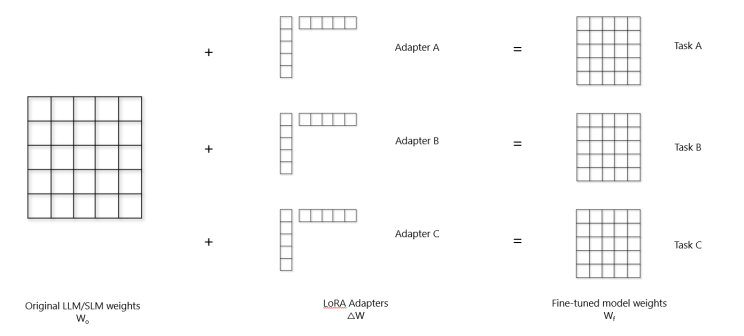

In [5]:
display(Image("/content/different_lora_adapters.png"))

In [6]:
# 140 * 0.75

105.0

In [ ]:
#  70,000 to 120,000

In [1]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [ ]:
# accelerate==0.21.0
# peft==0.4.0
# bitsandbytes==0.40.2
# transformers==4.31.0
# trl==0.4.7

In [2]:
dataset_name = "mlabonne/guanaco-llama2-1k"

In [3]:
from datasets import load_dataset

ModuleNotFoundError: No module named 'datasets'

In [ ]:
dataset = load_dataset(dataset_name, split='train')

In [9]:
dataset[100]

{'text': '<s>[INST] cuanto es 2x2 xD [/INST] La respuesta es 4. </s><s>[INST] puedes demostrarme matematicamente que 2x2 es 4? [/INST] En una multiplicación, el producto es el resultado de sumar un factor tantas veces como indique el otro, es decir, si tenemos una operación v · n = x, entonces x será igual a v sumado n veces o n sumado v veces, por ejemplo, para la multiplicación 3 · 4 podemos sumar "3 + 3 + 3 + 3" o "4 + 4 + 4" y en ambos casos nos daría como resultado 12, para el caso de 2 · 2 al ser iguales los dos factores el producto sería "2 + 2" que es igual a 4 </s>'}

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [7]:
import torch

In [8]:
from transformers import BitsAndBytesConfig

bitsandbytesconfig = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float16
    )

In [9]:
from transformers import AutoModelForCausalLM

In [58]:
# torch.cuda.empty_cache()

In [11]:
model_name = "meta-llama/Llama-2-7b-chat-hf"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config = bitsandbytesconfig,
    device_map = {"":0},
    use_auth_token = True
)
model.config.use_cache = False
model.config.pretraining_tp = 1

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2193: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [ ]:
from peft import LoraConfig

In [ ]:
peft_config = LoraConfig(
    lora_alpha = 16,
    r = 16,
    lora_dropout=0.2,
    task_type="CAUSAL_LM"
)

In [ ]:
from peft import get_peft_model

model = get_peft_model(model, peft_config)

In [ ]:
model.print_trainable_parameters()

In [ ]:
8.3 million == trainable parameters



In [22]:
import torch

torch.tensor([0.00987], dtype=torch.int8)

tensor([0], dtype=torch.int8)

In [41]:
from transformers import TrainingArguments

In [46]:
training_arguments = TrainingArguments(
    output_dir = "finetuned_result",
    optim = "paged_adamw_32bit",
    save_steps =0,
    num_train_epochs=1


)

In [47]:
dataset

Dataset({
    features: ['text'],
    num_rows: 1000
})

In [48]:
from trl import SFTTrainer

In [49]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    args=training_arguments
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [50]:
trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 95.06 MiB is free. Process 11321 has 14.65 GiB memory in use. Of the allocated memory 14.30 GiB is allocated by PyTorch, and 231.41 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)